# Program - Plot domain-avg profiles in AM4

Content
- Read AM4 and SCM data
- Select time and region in AM4, and compute domain-averaged profiles
- Plot profiles using matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read AM4 and SCM data

In [2]:
#--- open AM4 data
datapath = "../data/"
#filename = "data-am4_20010725_8xdaily-temp.nc"
filename = "cm4p12_xanadu_am4p0_edmf_mynn.tt1-c96L33_am4p0_cm4amip_nudge2000_Jul2001.1x0m30d_432x2a.atmos_8xdaily_inst.lat_lon.nc.20010710.nc"

files_input = datapath+"/"+filename

#--- use xarray to open the files
data = xr.open_dataset(files_input)
data

<xarray.Dataset>
Dimensions:    (phalf: 34, lat: 180, bnds: 2, levhalf: 34, lon: 288, time: 8,
                pfull: 33)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * levhalf    (levhalf) float64 1.0 0.9959 0.9897 ... 0.008186 0.004 0.001
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * pfull      (pfull) float64 2.164 5.845 10.75 17.11 ... 985.4 992.8 997.9
  * phalf      (phalf) float64 1.0 4.0 8.186 13.79 ... 981.1 989.7 995.9 1e+03
  * time       (time) object 2001-07-10 03:00:00 ... 2001-07-11 00:00:00
Dimensions without coordinates: bnds
Data variables: (12/18)
    bk         (phalf) float32 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    omega      (time, pfull, lat, lon) float32 ...
    pk         (phalf) float32 ...
    ps         (time, lat, lon) float32 ...
    ...         ...
    tdt_sw     (time, pfull, lat, lon) float32 ...
    temp       (time, pfull, lat, lon) float32 ...
    ucomp      (time, pfull, lat, lon) float32 ...
    vcomp      (time, pfull, lat, lon) float32 ...
    zg         (time, levhalf, lat, lon) float32 ...
    zsurf      (lat, lon) float32 ...
Attributes:
    filename:              20010701.atmos_8xdaily_inst.tile1.nc
    title:                 tt1-c96L33_am4p0_cm4amip_nudge2000_Jul2001
    associated_files:      area: 20010701.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Sat Jul 23 17:41:41 2022
    hostname:              an005
    history:               Sat Jul 23 17:58:48 2022: ncks -F -d time,73,80 ./...
    NCO:                   "4.5.4"

In [3]:
#--- read SCM data

datapath = "../data/"

filename_scm_1xdiv = "SCM_am4_xanadu_edmf_mynn.v01_RF01-00cc-am4p0_aerT_clr_am4RAD_sw.1x0m5d_1x1a.atmos_edmf_mynn.nc"
filename_scm_2xdiv = "SCM_am4_xanadu_edmf_mynn.v01_RF01-00cc-am4p0_aerT_clr_am4RAD_sw_2Xdifv.1x0m5d_1x1a.atmos_edmf_mynn.nc"

files_scm_1xdiv = datapath+"/"+filename_scm_1xdiv
files_scm_2xdiv = datapath+"/"+filename_scm_2xdiv

#--- use xarray to open the files
scm_1xdiv = xr.open_dataset(files_scm_1xdiv)
scm_2xdiv = xr.open_dataset(files_scm_2xdiv)

## read data & print out variables for computing tendencies from vertical advection using SCM machinery

In [29]:
#--- set up
region = "DYCOMS"
#region = "Californian_Sc"
model = "AM4_L33_native"
time_step = "2001-07-10 09:00:00"

#--- get lat/lon of the region
lon_slice, lat_slice = yhc.get_region_latlon(region)

#--- read data
pt = data.temp.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
qq = data.sphum.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
omega = data.omega.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_dyn = data.tdt_dyn.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_nudge = data.tdt_nudge.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_lw = data.tdt_lw.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_sw = data.tdt_sw.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
qdt_dyn = data.qdt_dyn.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
zg = data.zg.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))

#--- read pressure levels
ps_region = data.ps.sel(lat=lat_slice, lon=lon_slice)
pfull_region = yhc.mlevs_to_plevs(ps_region, model = model, plevs = "pfull").stack(loc=("lat","lon"))
phalf_region = yhc.mlevs_to_plevs(ps_region, model = model, plevs = "phalf").stack(loc=("lat","lon"))

phalf = phalf_region.sel(time=time_step)

nn = 0
#do_print = True
do_print = False


if (do_print):
    for nn in range(0,6):
        yhc.printv(phalf[0,:,nn],"phalf, n-th location = "+str(nn))
        yhc.printv(omega[0,:,nn],"omega, n-th location = "+str(nn))
        yhc.printv(pt[0,:,nn],"temp, n-th location = "+str(nn))
        yhc.printv(qq[0,:,nn],"qq, n-th location = "+str(nn))


<xarray.DataArray 'tdt_sw' (time: 1, pfull: 33, loc: 6)>
array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 

## Output from SCM machinery

In [6]:
#*********************
#
# SCM experiment: xx2-RF01_A-vert_adv_offline_1x0m2d_1x1a.o269063129
#
#*********************

#--- create DataArray
tdt_vadv = tdt_dyn.copy()
qdt_vadv = qdt_dyn.copy()
tdt_adi  = tdt_dyn.copy()

tdt_vadv.attrs['long_name']='tdt_vadv'
qdt_vadv.attrs['long_name']='qdt_vadv'
tdt_adi.attrs['long_name']='tdt_adi'

#--- tdt & qdt vertical advection for each grid point
nn=0
tdt_vadv[0,:,nn] = [0.1657E-04  ,  0.7775E-05  ,  0.5102E-05  ,  0.9575E-05  ,  0.1861E-04  ,  0.3166E-04  ,  0.3315E-04  ,  0.1702E-04  ,  0.4020E-04  ,  0.1310E-03  ,  0.8217E-04  ,  0.9168E-04  ,  0.1919E-04  , -0.3824E-04  , -0.2704E-04  ,  0.8152E-05  ,  0.2970E-04  ,  0.3098E-04  ,  0.2543E-04  ,  0.3364E-04  ,  0.3599E-04  ,  0.4339E-04  ,  0.2430E-04  ,  0.5833E-04  ,  0.7494E-04  ,  0.2805E-03  ,  0.5484E-04  , -0.2356E-04  , -0.8633E-06  , -0.6583E-06  , -0.5799E-06  , -0.5453E-06  , -0.1214E-05]
tdt_adi[0,:,nn]  = [0.1657E-04  ,  0.4702E-05  ,  0.4188E-05  ,  0.8084E-05  ,  0.1554E-04  ,  0.2607E-04  ,  0.2738E-04  ,  0.1071E-04  ,  0.3511E-04  ,  0.1305E-03  ,  0.1996E-03  ,  0.1465E-03  ,  0.2366E-04  , -0.6894E-04  , -0.5833E-04  ,  0.2509E-04  ,  0.7581E-04  ,  0.8725E-04  ,  0.8782E-04  ,  0.8297E-04  ,  0.8904E-04  ,  0.9452E-04  ,  0.8804E-04  ,  0.8072E-04  ,  0.7529E-04  ,  0.6503E-04  ,  0.5085E-04  ,  0.3630E-04  ,  0.2456E-04  ,  0.1549E-04  ,  0.8414E-05  ,  0.3137E-05  , -0.4967E-06]
qdt_vadv[0,:,nn] = [0.0000E+00  , -0.9625E-14  , -0.2569E-14  , -0.4082E-16  ,  0.2215E-13  ,  0.9252E-13  ,  0.1487E-12  ,  0.4039E-14  , -0.1027E-11  , -0.9454E-14  ,  0.6606E-12  , -0.3181E-10  , -0.8473E-11  ,  0.5065E-09  ,  0.1156E-08  , -0.8141E-09  , -0.3794E-08  , -0.1564E-08  , -0.3752E-09  , -0.2556E-07  , -0.1366E-07  , -0.9069E-09  ,  0.3505E-08  , -0.1513E-08  ,  0.5099E-07  , -0.1095E-06  , -0.4832E-07  , -0.4758E-08  , -0.1329E-08  , -0.8643E-09  , -0.5333E-09  , -0.5491E-09  , -0.2494E-09]

nn=1
tdt_vadv[0,:,nn] = [-0.1398E-04  , -0.1290E-04  , -0.4588E-05  ,  0.2383E-05  ,  0.1310E-04  ,  0.1954E-04  ,  0.3322E-04  ,  0.1645E-04  ,  0.2910E-04  ,  0.1235E-03  ,  0.6957E-04  ,  0.7762E-04  ,  0.3180E-04  , -0.8965E-05  , -0.1196E-04  , -0.1039E-04  ,  0.1875E-04  ,  0.3346E-04  ,  0.2792E-04  ,  0.3386E-04  ,  0.3926E-04  ,  0.4372E-04  ,  0.5912E-04  ,  0.2437E-04  ,  0.6164E-04  ,  0.3443E-03  ,  0.9255E-04  , -0.1376E-04  , -0.1412E-05  , -0.8519E-06  , -0.6939E-06  , -0.5905E-06  , -0.1779E-05]
tdt_adi[0,:,nn]  = [-0.1129E-04  , -0.1058E-04  , -0.4215E-05  ,  0.1745E-05  ,  0.1119E-04  ,  0.1538E-04  ,  0.2784E-04  ,  0.1118E-04  ,  0.2205E-04  ,  0.1225E-03  ,  0.1838E-03  ,  0.1405E-03  ,  0.4852E-04  , -0.1093E-04  , -0.2493E-04  , -0.3179E-05  ,  0.5930E-04  ,  0.9186E-04  ,  0.8119E-04  ,  0.8083E-04  ,  0.9834E-04  ,  0.1141E-03  ,  0.1132E-03  ,  0.1007E-03  ,  0.8766E-04  ,  0.7411E-04  ,  0.5813E-04  ,  0.4078E-04  ,  0.2662E-04  ,  0.1614E-04  ,  0.8218E-05  ,  0.2404E-05  , -0.1543E-05]
qdt_vadv[0,:,nn] = [0.4473E-14  ,  0.1510E-13  , -0.6849E-17  ,  0.1343E-14  ,  0.1231E-13  ,  0.8094E-13  ,  0.1256E-12  ,  0.5144E-14  , -0.7369E-12  ,  0.1211E-11  , -0.4721E-11  , -0.1154E-10  , -0.5718E-10  ,  0.1150E-09  ,  0.3980E-09  , -0.4321E-09  , -0.2875E-08  , -0.1909E-08  , -0.1595E-08  , -0.2736E-07  , -0.2006E-07  , -0.3063E-08  ,  0.5934E-08  ,  0.7660E-09  ,  0.4868E-07  ,  0.9406E-08  , -0.1701E-06  , -0.1255E-07  , -0.2782E-08  , -0.1136E-08  , -0.6646E-09  , -0.4593E-09  , -0.8013E-10]

nn=2
tdt_vadv[0,:,nn] = [-0.5679E-04  , -0.4999E-04  , -0.3374E-04  , -0.2620E-04  , -0.1520E-04  , -0.1074E-04  ,  0.1240E-04  ,  0.1752E-05  ,  0.3825E-05  ,  0.7874E-04  ,  0.4273E-04  ,  0.6001E-04  ,  0.4801E-04  ,  0.2509E-04  , -0.1505E-05  , -0.3445E-04  ,  0.7452E-06  ,  0.3240E-04  ,  0.3937E-04  ,  0.4188E-04  ,  0.3809E-04  ,  0.2857E-04  ,  0.5423E-04  ,  0.3919E-04  ,  0.3451E-04  ,  0.2276E-03  ,  0.1284E-03  ,  0.3685E-04  , -0.1642E-04  , -0.9235E-06  , -0.6339E-06  ,  0.2744E-05  , -0.1002E-04]
tdt_adi[0,:,nn]  = [-0.4639E-04  , -0.3970E-04  , -0.2939E-04  , -0.2317E-04  , -0.1288E-04  , -0.9990E-05  ,  0.1129E-04  ,  0.9770E-06  , -0.5023E-06  ,  0.7797E-04  ,  0.1284E-03  ,  0.1193E-03  ,  0.7939E-04  ,  0.4963E-04  , -0.8686E-05  , -0.5431E-04  ,  0.1850E-04  ,  0.8818E-04  ,  0.9241E-04  ,  0.9083E-04  ,  0.9527E-04  ,  0.1004E-03  ,  0.1000E-03  ,  0.8960E-04  ,  0.7515E-04  ,  0.6324E-04  ,  0.5146E-04  ,  0.3639E-04  ,  0.2143E-04  ,  0.9512E-05  ,  0.6557E-06  , -0.5737E-05  , -0.1002E-04]
qdt_vadv[0,:,nn] = [0.1653E-13  ,  0.7208E-13  , -0.5815E-15  , -0.7338E-14  , -0.1504E-13  , -0.5041E-14  ,  0.1578E-13  ,  0.1179E-14  , -0.6174E-14  ,  0.4649E-12  , -0.2473E-11  , -0.3087E-11  , -0.9770E-10  , -0.1535E-09  , -0.9250E-11  ,  0.3959E-09  , -0.1724E-08  , -0.4444E-08  , -0.1372E-07  , -0.2261E-07  , -0.9992E-08  , -0.3293E-08  , -0.5036E-09  ,  0.1361E-07  ,  0.9530E-08  ,  0.4741E-07  , -0.1383E-06  , -0.2885E-07  , -0.3732E-08  , -0.8167E-09  , -0.1385E-09  ,  0.2017E-08  ,  0.0000E+00]

nn=3
tdt_vadv[0,:,nn] = [0.1423E-04  , -0.3881E-05  ,  0.2717E-05  ,  0.8219E-05  ,  0.1025E-04  ,  0.2763E-04  ,  0.4521E-04  ,  0.3051E-04  ,  0.2405E-04  ,  0.1104E-03  ,  0.7941E-04  ,  0.8497E-04  ,  0.2334E-04  , -0.2095E-04  , -0.1998E-04  ,  0.1498E-04  ,  0.1652E-04  ,  0.4179E-05  ,  0.1103E-04  ,  0.2238E-04  ,  0.2650E-04  ,  0.2787E-04  ,  0.1240E-04  ,  0.5453E-04  ,  0.2075E-03  ,  0.1554E-03  ,  0.4786E-04  , -0.2174E-04  , -0.9223E-06  , -0.5890E-06  , -0.4569E-06  , -0.3943E-06  , -0.9400E-06]
tdt_adi[0,:,nn]  = [0.1423E-04  , -0.4139E-05  ,  0.2156E-05  ,  0.7223E-05  ,  0.8015E-05  ,  0.2216E-04  ,  0.3755E-04  ,  0.2324E-04  ,  0.2190E-04  ,  0.1103E-03  ,  0.1827E-03  ,  0.1252E-03  ,  0.2859E-04  , -0.3648E-04  , -0.3439E-04  ,  0.3071E-04  ,  0.3959E-04  ,  0.2598E-04  ,  0.4259E-04  ,  0.5670E-04  ,  0.6682E-04  ,  0.6586E-04  ,  0.6398E-04  ,  0.7108E-04  ,  0.7591E-04  ,  0.6554E-04  ,  0.4714E-04  ,  0.3059E-04  ,  0.1941E-04  ,  0.1171E-04  ,  0.6137E-05  ,  0.2156E-05  , -0.5012E-06]
qdt_vadv[0,:,nn] = [0.4308E-28  , -0.4604E-15  , -0.3642E-14  , -0.9914E-15  ,  0.1266E-13  ,  0.1161E-12  ,  0.1756E-12  ,  0.4310E-14  , -0.8240E-12  ,  0.2446E-12  ,  0.2270E-12  , -0.4062E-10  , -0.2294E-10  ,  0.2856E-09  ,  0.4774E-09  , -0.4770E-09  , -0.1815E-08  , -0.1047E-08  , -0.2337E-10  , -0.1832E-07  , -0.4597E-08  ,  0.1389E-07  ,  0.5169E-08  ,  0.3989E-08  ,  0.1477E-07  , -0.1364E-06  , -0.3757E-07  , -0.4016E-08  , -0.1071E-08  , -0.6786E-09  , -0.4079E-09  , -0.3957E-09  , -0.1617E-09]

nn=4
tdt_vadv[0,:,nn] = [-0.2564E-04  , -0.3842E-04  , -0.2355E-04  , -0.3901E-05  ,  0.6151E-05  ,  0.6505E-05  ,  0.3277E-04  ,  0.3030E-04  ,  0.8811E-05  ,  0.1012E-03  ,  0.7622E-04  ,  0.7874E-04  ,  0.3466E-04  , -0.9680E-05  , -0.1671E-04  ,  0.4173E-05  ,  0.9706E-05  ,  0.7481E-06  ,  0.7253E-05  ,  0.2629E-04  ,  0.3675E-04  ,  0.3654E-04  ,  0.3376E-04  ,  0.3441E-04  ,  0.6970E-04  ,  0.3359E-03  ,  0.7998E-04  , -0.1944E-04  , -0.1164E-05  , -0.8722E-06  , -0.6528E-06  , -0.2062E-06  , -0.2705E-05]
tdt_adi[0,:,nn]  = [-0.1877E-04  , -0.3104E-04  , -0.2124E-04  , -0.3490E-05  ,  0.5524E-05  ,  0.3965E-05  ,  0.2712E-04  ,  0.2459E-04  ,  0.5499E-05  ,  0.1008E-03  ,  0.1826E-03  ,  0.1309E-03  ,  0.4584E-04  , -0.1485E-04  , -0.3211E-04  ,  0.4722E-05  ,  0.2157E-04  ,  0.1606E-04  ,  0.3131E-04  ,  0.6136E-04  ,  0.8555E-04  ,  0.8740E-04  ,  0.7935E-04  ,  0.7582E-04  ,  0.7779E-04  ,  0.7311E-04  ,  0.5880E-04  ,  0.4058E-04  ,  0.2536E-04  ,  0.1450E-04  ,  0.6661E-05  ,  0.1054E-05  , -0.2705E-05]
qdt_vadv[0,:,nn] = [0.8469E-14  ,  0.2564E-13  ,  0.2243E-13  ,  0.1450E-27  ,  0.3168E-14  ,  0.6026E-13  ,  0.1045E-12  ,  0.3787E-14  , -0.5173E-12  ,  0.1071E-11  , -0.4671E-11  , -0.2045E-10  , -0.5723E-10  ,  0.1768E-09  ,  0.5431E-09  , -0.1105E-09  , -0.6032E-09  , -0.9777E-10  ,  0.1548E-09  , -0.1905E-07  , -0.1707E-07  , -0.2766E-08  ,  0.2131E-07  ,  0.8039E-08  ,  0.2375E-07  , -0.5517E-07  , -0.1268E-06  , -0.1105E-07  , -0.2654E-08  , -0.1005E-08  , -0.5430E-09  , -0.1096E-09  ,  0.0000E+00]

nn=5
tdt_vadv[0,:,nn] = [-0.4060E-04  , -0.5540E-04  , -0.4666E-04  , -0.2607E-04  , -0.1128E-04  , -0.1780E-04  ,  0.1176E-04  ,  0.1594E-04  , -0.1515E-04  ,  0.7115E-04  ,  0.5848E-04  ,  0.6321E-04  ,  0.4302E-04  ,  0.5583E-05  , -0.1811E-04  , -0.2801E-04  , -0.2280E-05  ,  0.1646E-04  ,  0.2257E-04  ,  0.3146E-04  ,  0.3282E-04  ,  0.2576E-04  ,  0.3444E-04  ,  0.1900E-04  ,  0.3304E-04  ,  0.2468E-03  ,  0.1003E-03  ,  0.4133E-04  , -0.1913E-04  , -0.9774E-06  , -0.7604E-06  ,  0.2769E-05  , -0.1071E-04]
tdt_adi[0,:,nn]  = [-0.3063E-04  , -0.4363E-04  , -0.4138E-04  , -0.2302E-04  , -0.8805E-05  , -0.1638E-04  ,  0.9913E-05  ,  0.1474E-04  , -0.1690E-04  ,  0.7078E-04  ,  0.1483E-03  ,  0.1152E-03  ,  0.5953E-04  ,  0.3384E-05  , -0.5756E-04  , -0.7011E-04  , -0.8164E-05  ,  0.4430E-04  ,  0.5918E-04  ,  0.6991E-04  ,  0.7473E-04  ,  0.7132E-04  ,  0.6460E-04  ,  0.5774E-04  ,  0.5658E-04  ,  0.5766E-04  ,  0.5340E-04  ,  0.4125E-04  ,  0.2573E-04  ,  0.1224E-04  ,  0.1867E-05  , -0.5665E-05  , -0.1071E-04]
qdt_vadv[0,:,nn] = [0.1154E-13  ,  0.4484E-13  ,  0.4195E-13  , -0.8531E-15  , -0.1054E-13  , -0.2400E-13  ,  0.6479E-14  ,  0.1847E-12  ,  0.0000E+00  ,  0.4383E-12  , -0.1979E-11  , -0.7278E-11  , -0.7991E-10  ,  0.2113E-09  ,  0.1004E-08  ,  0.1131E-08  ,  0.2539E-09  , -0.5643E-09  , -0.1203E-08  , -0.1842E-07  , -0.1762E-07  , -0.5208E-08  ,  0.1002E-07  ,  0.1111E-07  ,  0.1459E-07  ,  0.1008E-07  , -0.1414E-06  , -0.3014E-07  , -0.4627E-08  , -0.1252E-08  , -0.2536E-09  ,  0.1964E-08  ,  0.0000E+00]


## Making variables for plotting

In [39]:
#--- compute horizontal advection tendencies
tdt_hadv = tdt_dyn - tdt_vadv
tdt_hadv.attrs['long_name']="tdt_hadv"

qdt_hadv = qdt_dyn - qdt_vadv
qdt_hadv.attrs['long_name']="qdt_hadv"

dT_vadv = tdt_vadv - tdt_adi
dT_vadv.attrs['long_name']="dT_vadv"

#--- get domain-avg geopotential height
zg_ijavg = zg[0,:].mean("loc")
zfull = zg_ijavg.rolling(levhalf=2, center=True).mean().dropna("levhalf")
zfull = zfull[::-1]

#--- get domain-avg temp, specific humidity, and omega
pt_ijavg = pt[0,:,:].mean("loc")
qq_ijavg = qq[0,:,:].mean("loc")
omega_ijavg = omega[0,:,:].mean("loc")

#--- get domain-avg profiles for plotting
tdt_dyn_ijavg = tdt_dyn[0,:,:].mean("loc")
tdt_hadv_ijavg = tdt_hadv[0,:,:].mean("loc")
tdt_vadv_ijavg = tdt_vadv[0,:,:].mean("loc")
tdt_adi_ijavg = tdt_adi[0,:,:].mean("loc")
dT_vadv_ijavg = dT_vadv[0,:,:].mean("loc")
tdt_nudge_ijavg = tdt_nudge[0,:,:].mean("loc")
tdt_lw_ijavg = tdt_lw[0,:,:].mean("loc")

qdt_dyn_ijavg = qdt_dyn[0,:,:].mean("loc")
qdt_hadv_ijavg = qdt_hadv[0,:,:].mean("loc")
qdt_vadv_ijavg = qdt_vadv[0,:,:].mean("loc")

#yhc.printv(tdt_dyn_ijavg, "tdt_dyn_ijavg")
#yhc.printv(tdt_vadv_ijavg, "tdt_vadv_ijavg")
#yhc.printv(tdt_hadv_ijavg, "tdt_hadv_ijavg")


## plott - tdt

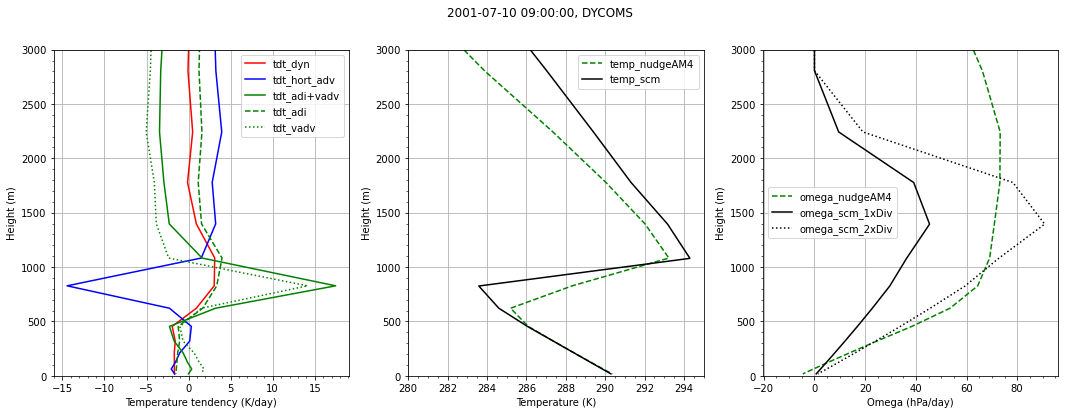

In [48]:
zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#opt_ax1 = "tdt_all"
opt_ax1 = "tdt_dyn"

if (opt_ax1 == "tdt_all"): 
    #--- subplot 1: temp tendencies
    ax1.plot(tdt_dyn_ijavg*86400., zfull, 'r-',
             tdt_nudge_ijavg*86400., zfull, 'r:',
             tdt_hadv_ijavg*86400., zfull,'b--',
             tdt_vadv_ijavg*86400., zfull,'g--',
             tdt_lw_ijavg*86400., zfull,'y-',
             scm_1xdiv.tdt_vadv[0,:,0,0]*86400., scm_1xdiv.zfull[0,:,0,0], 'k',
             scm_2xdiv.tdt_vadv[0,:,0,0]*86400., scm_2xdiv.zfull[0,:,0,0], 'k:',
             #tdt_adi_ijavg*86400., zfull,'g:',
        )
    ax1.legend(["tdt_dyn","tdt_nudge","tdt_hort_adv","tdt_vert_adv","tdt_lw","tdt_scm_1xDiv","tdt_scm_2xDiv"])

elif (opt_ax1 == "tdt_dyn"):
    ax1.plot(tdt_dyn_ijavg*86400., zfull, 'r-',
             tdt_hadv_ijavg*86400., zfull,'b-',
             tdt_vadv_ijavg*86400., zfull,'g-',
             tdt_adi_ijavg*86400., zfull,'g--',
             dT_vadv_ijavg*86400., zfull,'g:',
        )
    ax1.legend(["tdt_dyn","tdt_hort_adv","tdt_adi+vadv","tdt_adi","tdt_vadv"])
    #ax1.set_xlim([-10., 10.])

    
ax1.grid(True)
ax1.set_ylim([zmin, zmax])
#ax1.legend(["tdt_dyn","tdt_nudge","tdt_hort_adv","tdt_vert_adv","tdt_lw","tdt_scm_1xDiv","tdt_scm_2xDiv"])
ax1.set_xlabel("Temperature tendency (K/day)")
ax1.set_ylabel("Height (m)")

#ax1.set_xlim([-15., 15.])
ax1.minorticks_on()

#--- subplot 2: temperature
ax2.plot(pt_ijavg, zfull, 'g--',
         scm_1xdiv.temp[0,:,0,0], scm_1xdiv.zfull[0,:,0,0], 'k-',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
ax2.set_xlim([280., 295.])

ax2.legend(["temp_nudgeAM4","temp_scm"])
ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel("Height (m)")

ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'g--', 
         scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k-',
         scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")

ax3.minorticks_on()



## Plot - qdt

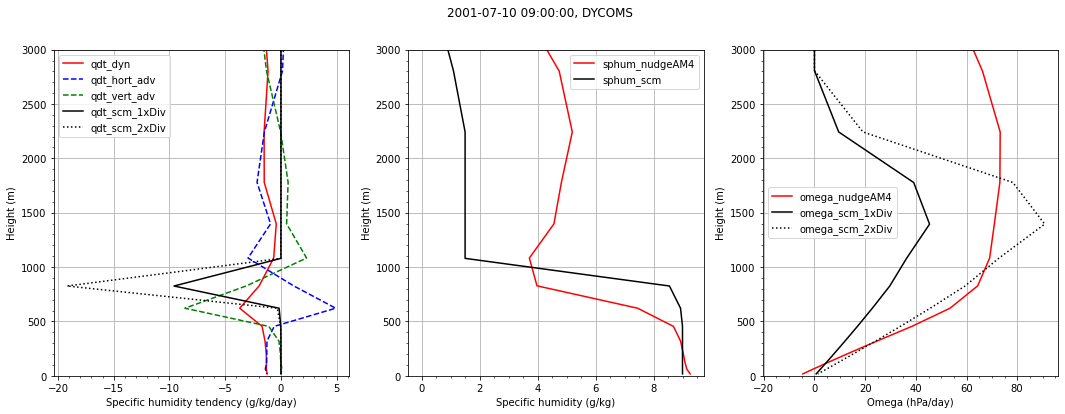

In [8]:
zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#--- subplot 1: temp tendencies
ax1.plot(qdt_dyn_ijavg*86400.*1000., zfull, 'r',
         qdt_hadv_ijavg*86400.*1000., zfull,'b--',
         qdt_vadv_ijavg*86400.*1000., zfull,'g--',
         scm_1xdiv.qvdt_vadv[0,:,0,0]*86400.*1000., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.qvdt_vadv[0,:,0,0]*86400.*1000., scm_2xdiv.zfull[0,:,0,0], 'k:'
        )
ax1.grid(True)
ax1.set_ylim([zmin, zmax])
ax1.legend(["qdt_dyn","qdt_hort_adv","qdt_vert_adv","qdt_scm_1xDiv","qdt_scm_2xDiv"])
ax1.set_xlabel("Specific humidity tendency (g/kg/day)")
ax1.set_ylabel("Height (m)")
ax1.minorticks_on()

#--- subplot 2: temperature
ax2.plot(qq_ijavg*1000., zfull, 'r',
         scm_1xdiv.sphum[0,:,0,0]*1000., scm_1xdiv.zfull[0,:,0,0], 'k',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
#ax2.set_xlim([280., 295.])

ax2.legend(["sphum_nudgeAM4","sphum_scm"])
ax2.set_xlabel("Specific humidity (g/kg)")
ax2.set_ylabel("Height (m)")
ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'r', 
         scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")
ax3.minorticks_on()

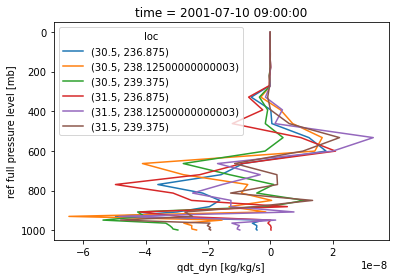

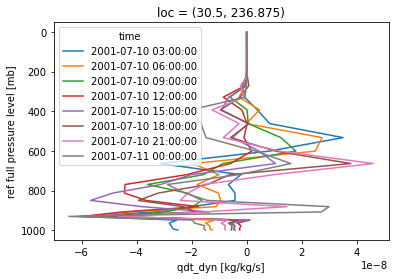

In [9]:
#--- quick plot
time_step = "2001-07-10 07:30:00"
var_region = data.qdt_dyn.sel(lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))

tt = 2
var = var_region[tt, :,:]
#print(var)

var.plot.line(y="pfull", yincrease=False)
plt.show()

nn=0
var_tp = var_region[:,:,nn]
var_tp.plot.line(y="pfull", yincrease=False)
plt.show()